<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Знакомство-с-данными" data-toc-modified-id="Знакомство-с-данными-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Знакомство с данными</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Проведем очистку, лемматизацию текстов и закодируем для обучения моделей. Проверять будем Логистическую регрессию, случайный лес и LGBM, выберем лучшую с результатом по f1 не менее 0,75. Результаты сравним и протестируем лучшую модель 

## Подготовка

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import contextlib
import re 
import nltk
from nltk.corpus import stopwords as nltk_stopwords
import spacy

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### Знакомство с данными

In [14]:
try:
    df = pd.read_csv('toxic_comments.csv')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')

In [15]:
df.head(5)

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [16]:
df.shape

(159292, 3)

In [17]:
df.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [18]:
df.duplicated().sum()

0

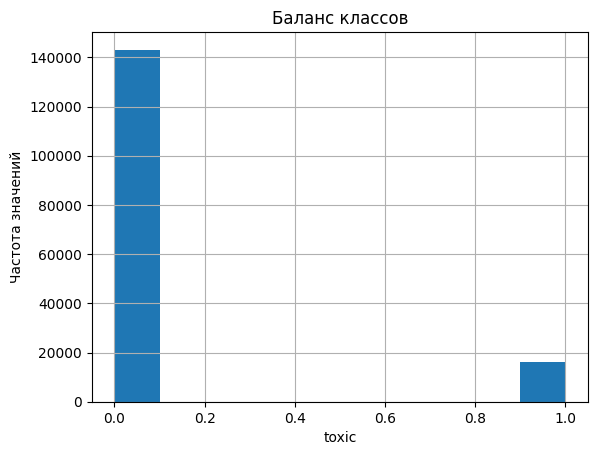

In [19]:
plt.title('Баланс классов')
plt.xlabel('toxic')
plt.ylabel('Частота значений')

df['toxic'].hist()

plt.show()

Все как в описании, такст и оценка токсичности. Ничего необычного. Пустых нет, размер в норме. Баланс классов сильно нарушен - учтем это при разбиении выборок и подборе моделей. Можем работать.

### Подготовка данных

Создадим функцию для лемматизации, результат которой станет фичами.

In [28]:
nlp = spacy.load("en_core_web_sm",  disable=['parser', 'ner'])

In [29]:
def lemmatizer(text):

    text = re.sub(r'[^a-zA-Z ]', ' ', text).split()  
    text = " ".join(text).lower()
    
    #spacy.prefer_gpu()
    
    doc = nlp(text)
    doc = " ".join([token.lemma_ for token in doc])
    
    return doc

In [30]:
corpus = df['text'].values

print(corpus[0],'\n')
print(lemmatizer(corpus[0]))


Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27 

explanation why the edit make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after I vote at new york dolls fac and please don t remove the template from the talk page since I m retire now


Лемматизация работает корректно. Теперь применим функцию ко всему датафрейму

In [31]:
%%time

tqdm.pandas()

spacy.prefer_gpu()
df['lemmatized'] = df['text'].progress_apply(lemmatizer)



  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: total: 14min 33s
Wall time: 14min 32s


In [34]:
features = df['lemmatized']
target = df['toxic'].values

features_train, features_test, target_train, target_test = \
    train_test_split(features, target, test_size=0.1, random_state=12345, stratify=target)

In [36]:
stopwords = list(nltk_stopwords.words('english'))  
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train_coded = count_tf_idf.fit_transform(features_train)
tf_idf = count_tf_idf
features_test_coded = count_tf_idf.transform(features_test)


Данные разделили на выборки определив таргет. Текст очищен и лемматизирован. Все готово к подбору модели

## Обучение

### Логистическая регрессия

Сделаем перебор гиперпараметров. Для этого используем функцию, которая будет принимать пайплайн с моделью и векторайзером, а также набор гиперпараметров для перебора. На выходе получим лучший скор и лучший эстиматор

In [37]:
def hyp_sercher(pipe, hyp_p):

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions = hyp_p,
        n_iter=3, cv=2, verbose=0, random_state=35, n_jobs = -1,
        scoring='f1'

    )

    search.fit(features_train, target_train) 

    print (
        'Лучшие параметры:', search.best_params_,'\n',
        'f1', search.best_score_,'\n'
    )  
    
    return search.best_estimator_


In [38]:
%%time

hyp_p = {
    'model__C': [int(x) for x in np.linspace(10, 120, num = 5)]
} 

pipe = Pipeline(
    [
    ('count_tf_idf',  TfidfVectorizer(stop_words=stopwords)),
    ('model', LogisticRegression(class_weight='balanced'))
    ]
)

log_model = hyp_sercher(pipe=pipe, hyp_p=hyp_p)

Лучшие параметры: {'model__C': 10} 
 f1 0.7648328387139114 

CPU times: total: 12.5 s
Wall time: 29.6 s


C:\Users\klyuchevenko.e\Desktop\DS\ya\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Случайный лес

In [37]:
%%time

hyp_p = {
    'model__n_estimators' : [int(x) for x in np.linspace(start = 1, stop = 20, num = 3)],
#    'model__max_features' : ['auto', 'sqrt'],
#    'model__max_depth' : [int(x) for x in np.linspace(10, 120, num = 8)],
#    'model__min_samples_split' : [2, 6, 12],
#    'model__min_samples_leaf' : [1, 3, 4]
} 

pipe = Pipeline(
    [
    ('count_tf_idf',  TfidfVectorizer(stop_words=stopwords)),
    ('model', RandomForestClassifier(class_weight='balanced', random_state=123))
    ]
)

forest_model = hyp_sercher(pipe=pipe, hyp_p=hyp_p)

Лучшие параметры: {'model__n_estimators': 20} 
 f1 0.5986326060431064 

CPU times: user 6min 30s, sys: 3.83 s, total: 6min 34s
Wall time: 6min 35s


### LightGBM

In [38]:
%%time

hyp_p = {
    'model__num_leaves' : [int(x) for x in np.linspace(start = 31, stop = 100, num = 3)],
    #'model__max_depth' : [0,-1] + [int(x) for x in np.linspace(start = 1, stop = 20, num = 2)],
} 

pipe = Pipeline(
    [
    ('count_tf_idf',  TfidfVectorizer(stop_words=stopwords)),
    ('model', LGBMClassifier(class_weight='balanced', random_state=123))
    ]
)

gbm_model = hyp_sercher(pipe=pipe, hyp_p=hyp_p)

Лучшие параметры: {'model__num_leaves': 100} 
 f1 0.7517716912468876 

CPU times: user 23min 47s, sys: 2.9 s, total: 23min 50s
Wall time: 23min 55s


Перебрав гиперпараметры для моделей LightGBM, RandomForest, LogisticRegression, получили значения лучших f1 и наилучший результат показала можель Логистической регрессии - 0,76 на подборе через RandomSearch

| Модель| f1 | test |
| --- | --- | --- |
| Логистическая регрессия | 0.76 | - |
| Случайный Лес | 0.59 | - |
| LGBM | 0.75 | - |

## Тестирование лучшей модели

In [39]:
predict_test = log_model[1].predict(features_test_coded)
f1_score(target_test, predict_test)

0.7754985754985755

## Выводы

| Модель| f1 | test |
| --- | --- | --- |
| Логистическая регрессия | 0.76 | 0.77 |
| Случайный Лес | 0.52 | - |
| LGBM | 0.74 | - |

В рамках проекта были рассмотрены f1-меры результатов работы трех моделей. Для каждой модели пыл подобран оптимальный набор гиперпараметров. Наилучший результат показал модель логистической регресси с f1 равной 0,77 на тренировочной выборке и аналогичным значенеим на тестовой